In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
d21 = pd.read_csv('./fully_correlated_data/data_21.csv')
d22 = pd.read_csv('./fully_correlated_data/data_22.csv')
d10 = pd.read_csv('./fully_correlated_data/data_10.csv')
d11 = pd.read_csv('./fully_correlated_data/data_11.csv')
d12 = pd.read_csv('./fully_correlated_data/data_12.csv')
d13 = pd.read_csv('./fully_correlated_data/data_13.csv')
d14 = pd.read_csv('./fully_correlated_data/data_14.csv')
d15 = pd.read_csv('./fully_correlated_data/data_15.csv')
d16 = pd.read_csv('./fully_correlated_data/data_16.csv')
d17 = pd.read_csv('./fully_correlated_data/data_17.csv')

In [3]:
comb_data = pd.concat([d10,d11,d12,d13,d14,d15,d16,d17,d21,d22], ignore_index = True)

In [4]:
comb_filt = comb_data.dropna()

#### Plot all selected boat paths

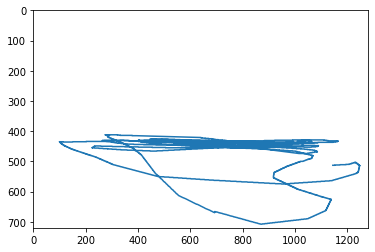

In [5]:
plt.xlim(left=0,right=1280)
plt.ylim(top=0,bottom=720)
plt.plot(comb_data.x_cent,comb_data.y_cent)

#### Define Google Earth Constants

In [6]:
RH_Point = np.array([-117.2244901, 32.6990683])
CAM = np.array([-117.2344652, 32.7029769])
RHS = (RH_Point-CAM)/np.linalg.norm(RH_Point-CAM)
RHS_Ang = np.arctan2(RHS[1],RHS[0])

### Extremely Simple Estimates
#### Find Optimal FOV Approximate

In [7]:
angles = np.arctan2(comb_data.lat_int.values,comb_data.lon_int.values)

In [8]:
comb_data['angles'] = angles

In [9]:
comb_data['angle_offset'] = angles - RHS_Ang

In [10]:
min_err = 1e10
best = None
error = []
iis = []
for i in np.arange(1,1.5,.0001):
    agr = (comb_data.angle_offset/i).values
    x_prop = (1-comb_data.x_cent/1280).values
    err = ((x_prop-agr)**2).mean()
    error.append(err)
    iis.append(i)
    if err < min_err:
        min_err = err
        best = i
        
FOV = best

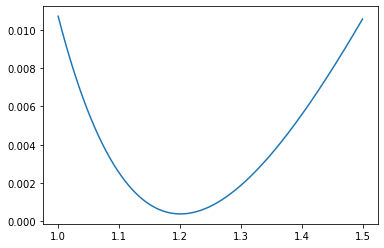

In [11]:
plt.plot(iis,error) #just look at that pretty convex loss profile *chef's kiss*

In [12]:
comb_data['angle_rel'] = comb_data.angle_offset/FOV

#### We can now find a nearly linear relationship between angle to boat and screen x position

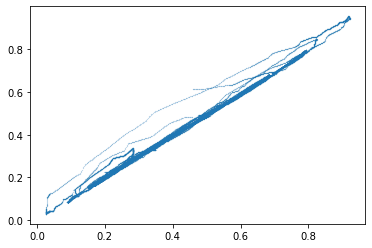

In [13]:
plt.scatter(1-comb_data.x_cent/1280,comb_data.angle_rel,.01)

#### Location and angle of center of view

In [14]:
COV = np.array([-117.2192825,32.7060566])
np.arccos(np.dot(RH_Point-CAM,COV-CAM)/np.linalg.norm(COV-CAM)/np.linalg.norm(RH_Point-CAM))*180/np.pi*2.009419152276295

66.03649611554884

#### Optimize for distance bbox-height relationship

In [15]:
distances = ((comb_data.lon_int**2+comb_data.lat_int**2)**.5).values

In [16]:
min_err = 1e10
best = None
error = []
iis = []
for i in np.arange(.00001,.00005,1e-6):
    est = i/(comb_data.height/720).values
    err = ((distances[:25000]-est[:25000])**2).mean()
    error.append(err)
    iis.append(i)
    if err < min_err:
        min_err = err
        best = i
        
factor = best

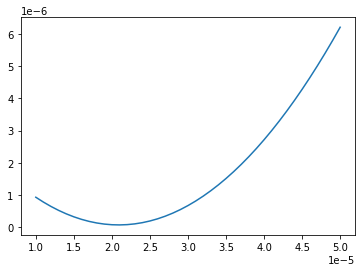

In [17]:
plt.plot(iis,error)

In [432]:
from scipy import stats

In [455]:
stats.describe(np.gradient(np.gradient(comb_filt.lat_int.values[:1000]*111111)))

DescribeResult(nobs=1000, minmax=(-6.2731603934531925, 7.199076134331856), mean=-0.0023056365828636864, variance=0.9327867719464027, skewness=0.6236780216965044, kurtosis=13.13450312046579)

In [18]:
comb_data.head()

,Frame No.,UTC Timestamp,Lat,Long,estimated_time,time,gps_lat,gps_lon,gps_lat_rel,gps_lon_rel,...,y,width,height,x_cent,y_cent,lat_int,lon_int,angles,angle_offset,angle_rel
0,0,19:48:52,32.70297,-117.234631,19:48:56.0,0.000000,NaN,NaN,NaN,NaN,...,426.00,33.0,12.000,1086.0,438.0,-0.000296,0.001517,-0.192723,0.180726,0.150504
1,1,19:48:52,32.70297,-117.234631,19:48:56.06,0.055556,NaN,NaN,NaN,NaN,...,426.01,33.0,11.993,1085.0,438.0,-0.000296,0.001517,-0.192723,0.180726,0.150504
2,2,19:48:52,32.70297,-117.234631,19:48:56.11,0.111111,NaN,NaN,NaN,NaN,...,426.03,33.0,11.986,1085.0,438.0,-0.000296,0.001517,-0.192723,0.180726,0.150504
3,3,19:48:52,32.70297,-117.234631,19:48:56.17,0.166667,NaN,NaN,NaN,NaN,...,426.04,33.0,11.979,1084.0,438.0,-0.000296,0.001517,-0.192723,0.180726,0.150504
4,4,19:48:52,32.70297,-117.234631,19:48:56.22,0.222222,NaN,NaN,NaN,NaN,...,426.06,33.0,11.972,1084.0,438.0,-0.000296,0.001517,-0.192723,0.180726,0.150504


#### Observe angle estimator performance on training data

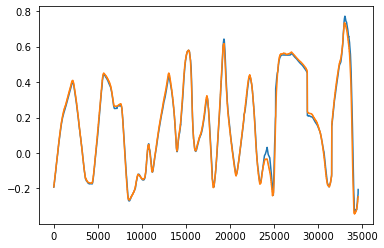

In [19]:
plt.plot(comb_data.angles)
plt.plot((1-comb_data.x_cent.values/1280)*FOV+RHS_Ang)

#### Optimize moving average filter length

In [20]:
def moving_average(a, n=367) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [21]:
min_err = 1e10
best = None
error = []
iis = []
for i in range(50,700):
    est = moving_average(factor/(comb_data[:25000].height.values/720),n=i)
    err = ((distances[:25001-i]-est[:25000])**2).mean()
    error.append(err)
    iis.append(i)
    if err < min_err:
        min_err = err
        best = i
        
window = best

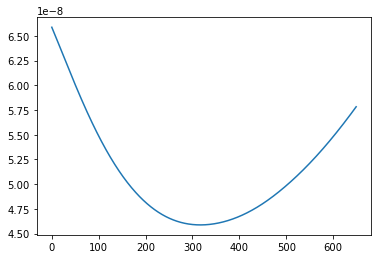

In [22]:
plt.plot(error)

In [23]:
window

367

#### Observe filtered distance estimator performance on training data

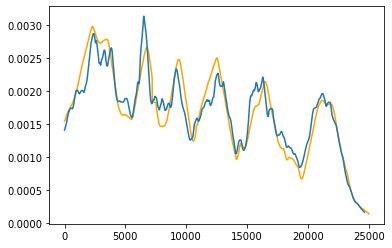

In [24]:
plt.plot(distances[:25000],color='orange')
plt.plot(moving_average(factor/(comb_data[:25000].height.values/720),n=367))

#### Use simple estimators to estimate latlon from bbox data

In [25]:
lon = factor/(moving_average(comb_data.height.values,window)/720)*np.cos((1-comb_data.x_cent.values[:34218]/1280)*FOV+RHS_Ang)
lat = factor/(moving_average(comb_data.height.values,window)/720)*np.sin((1-comb_data.x_cent.values[:34218]/1280)*FOV+RHS_Ang)
lont = distances*np.cos(comb_data.angle_offset+RHS_Ang)
latt = distances*np.sin(comb_data.angle_offset+RHS_Ang)

In [26]:
lon_mse = ((lon[:25000]-lont[:25000])**2).mean()
lat_mse = ((lat[:25000]-latt[:25000])**2).mean()
(lon_mse*288200**2+lat_mse*364000**2)**.5

62.16415483905954

In [401]:
def bbox_2_gps(x, height, width):
    factor = 1.2e-5
    FOV = 1.2007999999999779
    RHS_Ang = -0.373448408973746
    x_cent = x + width//2
    lon = factor/(height/720)*np.cos((1-x_cent/1280)*FOV+RHS_Ang)
    lat = factor/(height/720)*np.sin((1-x_cent/1280)*FOV+RHS_Ang)
    return lon, lat

def bbox_2_gps_fft(x, height, width, terms, mult):
    factor = 1.2e-5
    FOV = 1.2007999999999779
    RHS_Ang = -0.373448408973746
    x_cent = x + width//2
    dist = height/720#factor/(height/720)
    dft = np.fft.fft(dist)
    dft[terms:] = 0
    filt = np.fft.ifft(dft)
    filt = (filt-np.mean(filt))*mult+np.mean(dist)
    lon = mult*factor/filt*np.cos((1-x_cent/1280)*FOV+RHS_Ang)
    lat = mult*factor/filt*np.sin((1-x_cent/1280)*FOV+RHS_Ang)
    return lon, lat

    The above number indicates that on these training data, the simple estimator is off by an average of 62 feet on the first 25000 data points (before the boat travels beyond the resolution of the camera and the system breaks down)
#### Observe perfomance of simple estimators on training data

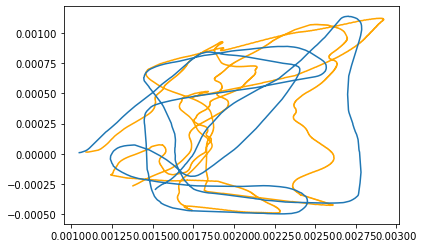

In [299]:
plt.plot(lon[:14000],lat[:14000],color='orange')
plt.plot(lont[:14000],latt[:14000])

#### Testing FFT Lowpass Filter

D:\Conda\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


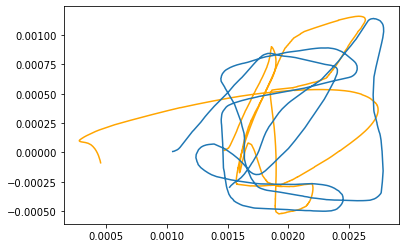

In [406]:
lo,lt = bbox_2_gps_fft(comb_data.x.values,comb_data.height.values,comb_data.width.values, 9, 2)
plt.plot(lo[:14000],lt[:14000],color='orange')
plt.plot(lont[:14000],latt[:14000])

#### Kalman Filter Test Distance

In [725]:
class K_Filter_Dist:
    def __init__(self, y0, var = .01, dt = 1/25):
        '''
            Ak = constant
            xh = [xh_k+1|k, xh_k|k]
            P = [P_k+1|k, P_k|k]
        '''
        self.dt = dt
        self.Ak = np.array([1, 0])
        self.xh = [None, np.array([y0,1.5e-5]).transpose()]
        self.P = [None, np.eye(2)*var]
        
    def inv(self, A):
        return np.linalg.inv(A)
    
    def state_update_extrap(self):
        self.Fk = np.array([[1, self.dt],
                            [0, 1]])
        self.xh[0] = np.dot(self.Fk, self.xh[1])
        
    def info_mtx_extrap(self):
        self.P[0] = np.dot(self.Fk, np.dot(self.P[1], self.Fk.transpose())) + np.eye(2)
        
    def kalman_gain(self):
        a = np.dot(self.Ak, np.dot(self.P[0], self.Ak.transpose())) + 1
        self.KG = np.dot(self.P[0], self.Ak.transpose()) * a**-1
        
    def state_update(self, yk1):
        self.xh[1] = self.xh[0] + np.dot(self.KG, (yk1 - np.dot(self.Ak, self.xh[0])))
        
    def info_mtx_update(self):
        self.P[1] = np.dot(np.eye(2) - np.dot(self.KG, self.Ak), self.P[0])
        
    def step_forward(self, yk1 = None, dt = 1/25):
        self.dt = dt
        self.state_update_extrap()
        self.info_mtx_extrap()
        self.kalman_gain()
        
        if type(yk1) != type(None):
            self.state_update(yk1)
            self.info_mtx_update()
        else:
            self.xh[1] = self.xh[0]
            self.P[1] = self.P[0]
        
        return self.xh[1][0]

In [192]:
dist = factor/(comb_data[:25000].height.values/720)

In [247]:
KF = K_Filter_Dist(dist[0], var = .1)

In [248]:
xs =[]
for i in range(24000*10):
    if i%10 == 0:
        xs.append(KF.step_forward(yk1=dist[(i//10+1)]))
    else:
        xs.append(KF.step_forward())
xs = np.array(xs)

D:\Conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


In [321]:
dft = np.fft.fft(dist)
dft[10:] = 0
filt = np.fft.ifft(dft)

D:\Conda\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


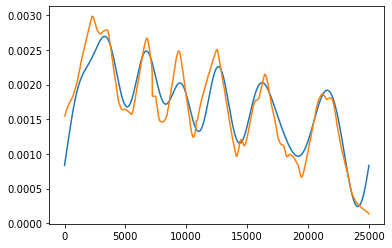

In [322]:
plt.plot((filt-np.mean(filt))*2+np.mean(filt))
plt.plot(distances[:25000])

#### Kalman Filter Test XY

In [407]:
class K_Filter:
    def __init__(self, y0, dt = 1/25):
        '''
            Ak = constant
            xh = [xh_k+1|k, xh_k|k]
            P = [P_k+1|k, P_k|k]
        '''
        self.dt = dt
        self.L = 1
        self.Ak = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0]])
        #self.xh = [None, np.dot(self.inv(np.dot(self.Ak.transpose(),self.Ak) + np.eye(5)),np.dot(self.Ak.transpose(), y0))] 
        #self.xh = [None, (np.dot(self.Ak.transpose(), y0) + np.array([0, 0, .1, .1, .1])).transpose()] 
        #self.xh = [None, np.array([y0[0],y0[1],9.48330544e-07,1.15878438e-06]).transpose()]
        self.xh = [None, np.array([y0[0],y0[1],(9.48330544e-07**2+1.15878438e-06**2)**.5,.2,.15]).transpose()]
        #self.P = [None, self.inv(np.dot(self.Ak.transpose(),self.Ak)) + np.diag([0,0,.1,.1,.1])]
        self.P = [None, np.eye(5)*.01]
        
    def inv(self, A):
        return np.linalg.inv(A)
    
    def state_update_extrap(self):
        self.Fk = np.array([[1, 0, np.cos(self.xh[1][3])*self.dt, 0, 0],
                            [0, 1, np.sin(self.xh[1][3])*self.dt, 0, 0],
                            [0, 0, 1, 0, 0],
                            [0, 0, 0, 1, self.dt],
                            [0, 0, 0, 0, 1]])
#         self.Fk = np.array([[1, 0, self.dt, 0],
#                             [0, 1, 0, self.dt],
#                             [0, 0, 1, 0],
#                             [0, 0, 0, 1]])
        self.xh[0] = np.dot(self.Fk, self.xh[1])
        
    def info_mtx_extrap(self):
        self.P[0] = np.dot(self.Fk, np.dot(self.P[1], self.Fk.transpose())) + np.eye(5)
        
    def kalman_gain(self):
        a = np.dot(self.Ak, np.dot(self.P[0], self.Ak.transpose())) + np.eye(2)
        self.KG = np.dot(self.P[0], np.dot(self.Ak.transpose(), self.inv(a)))
        
    def state_update(self, yk1):
        self.xh[1] = self.xh[0] + np.dot(self.KG, (yk1 - np.dot(self.Ak, self.xh[0])))
        
    def info_mtx_update(self):
        self.P[1] = np.dot(np.eye(5) - np.dot(self.KG, self.Ak), self.P[0])
        
    def step_forward(self, yk1 = None, dt = 1/25):
        self.dt = dt
        self.state_update_extrap()
        self.info_mtx_extrap()
        self.kalman_gain()
        
        if type(yk1) != type(None):
            self.state_update(yk1)
            self.info_mtx_update()
        else:
            self.xh[1] = self.xh[0]
            self.P[1] = self.P[0]
        
        return self.xh[1]

In [726]:
class K_Filter_3O:
    def __init__(self, y0, dt = 1/25):
        '''
            Ak = constant
            xh = [xh_k+1|k, xh_k|k]
            P = [P_k+1|k, P_k|k]
        '''
        self.dt = dt

        self.H = np.eye(6)
        self.xh = np.array([y0[0], y0[1], 1, 1, .1, .1])
        deltas = np.array([21, 21, 5.2, 4.7, 1.2, 1.2])
        self.P = np.dot(deltas.transpose(),deltas)

        self.F = np.array([[1, 0, self.dt, 0, .5*self.dt**2, 0],
                            [0, 1, 0, self.dt, 0, .5*self.dt**2],
                            [0, 0, 1, 0, self.dt, 0],
                            [0, 0, 0, 1, 0, self.dt],
                            [0, 0, 0, 0, 1, 0],
                            [0, 0, 0, 0, 0, 1]])
        self.R = 1.1*self.P
        self.acclim = 15 #m/s^2
        self.Q = np.diag([1, 1, 1, 1, 5, 5])
        
    def step(self, y = None, dt = 1/25):
        self.dt = dt
        self.predict_state()
        self.kalman_gain()
        
        if type(y) != type(None):
            self.current_state(y)
        
        self.process_cov_update()
        self.limit_acceleration()
        return self.xh
        
    def predict_state(self):
        self.xh = np.dot(self.F, self.xh)
        self.P = np.dot(self.F, np.dot(self.P, self.F.transpose()))
        
    def kalman_gain(self):
        A = np.dot(self.P, self.H.transpose())
        B = np.dot(self.H, np.dot(self.P, self.H.transpose())) + self.R
        self.KG = A/B
        
    def current_state(self, y):
        self.xh = self.xh + np.dot(self.KG, (y - np.dot(self.H, self.xh)))
        
    def process_cov_update(self):
        A = (np.eye(6) - np.dot(self.KG,self.H))
        self.P = np.dot(A, self.P)
        
    def limit_acceleration(self):
        self.xh[4:] = np.clip(self.xh[4:],-13,13)

In [727]:
ys = np.array([lon[:14000]*111111,lat[:14000]*111111])

In [745]:
L = ys.shape[1]
dlon = np.reshape(np.gradient(ys[0]), (1,L))*.01
dlat = np.reshape(np.gradient(ys[1]), (1,L))*.01
ddlon = np.reshape(np.gradient(dlon[0,:]), (1,L))*.01
ddlat = np.reshape(np.gradient(dlat[0,:]), (1,L))*.01
Y = np.concatenate((ys,dlon,dlat,ddlon,ddlat),axis=0)

In [746]:
KF = K_Filter_3O(Y[:,0])

In [747]:
xs =[]
for i in range(13000):
    if i%1 == 0:
        xs.append(KF.step(y=Y[:,i+1],dt=1/25))
    else:
        xs.append(KF.step())
xs = np.array(xs)

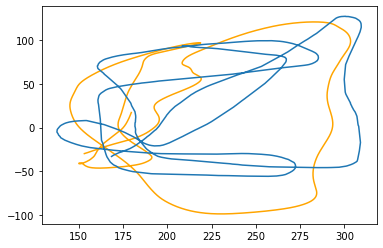

In [748]:
plt.plot(xs[:13000,0],xs[:13000,1],color='orange')
plt.plot(lont[:13000]*111111,latt[:13000]*111111)

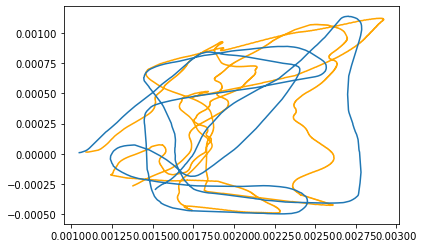

In [749]:
plt.plot(lon[:14000],lat[:14000],color='orange')
plt.plot(lont[:14000],latt[:14000])

#### Try to approximate the nonlinear transformation from screen position/size to distance

In [80]:
model = keras.models.Sequential([
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(16, activation = 'linear'),
    keras.layers.Dense(2, activation = 'linear')
])
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanSquaredError()],
)


In [207]:
maxes = np.array([max(full_data_6.lon_lin),max(full_data_6.lat_lin)])

In [212]:
model.fit((full_data_6[['x','y']].values/np.array([1280,720]))[:3000],full_data_6[['R','angles']].values[:3000],#/maxes,
          validation_data =(full_data_6[['x','y']].values[3000:]/np.array([1280,720]),full_data_6[['R','angles']].values[3000:]),#/maxes), 
         batch_size = 8,
         epochs = 50,
         verbose = 1)

Epoch 1/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 4.3255e-04 - val_mean_squared_error: 4.3255e-04
Epoch 2/50
375/375 [==============================] - 1s 2ms/step - loss: 1.2359e-04 - mean_squared_error: 1.2359e-04 - val_loss: 4.2599e-04 - val_mean_squared_error: 4.2599e-04
Epoch 3/50
375/375 [==============================] - 1s 2ms/step - loss: 1.2431e-04 - mean_squared_error: 1.2431e-04 - val_loss: 4.1176e-04 - val_mean_squared_error: 4.1176e-04
Epoch 4/50
375/375 [==============================] - 1s 2ms/step - loss: 1.2078e-04 - mean_squared_error: 1.2078e-04 - val_loss: 3.6795e-04 - val_mean_squared_error: 3.6795e-04
Epoch 5/50
375/375 [==============================] - 1s 2ms/step - loss: 1.2858e-04 - mean_squared_error: 1.2858e-04 - val_loss: 4.2737e-04 - val_mean_squared_error: 4.2737e-04
Epoch 6/50
375/375 [==============================] - 1s 2ms/step - loss: 1.3309e-04 - mean_squared_error: 1.3309e-04 

Epoch 47/50
375/375 [==============================] - 1s 2ms/step - loss: 1.4276e-04 - mean_squared_error: 1.4276e-04 - val_loss: 5.4665e-04 - val_mean_squared_error: 5.4665e-04
Epoch 48/50
375/375 [==============================] - 1s 2ms/step - loss: 1.3209e-04 - mean_squared_error: 1.3209e-04 - val_loss: 2.7948e-04 - val_mean_squared_error: 2.7948e-04
Epoch 49/50
375/375 [==============================] - 1s 2ms/step - loss: 1.3109e-04 - mean_squared_error: 1.3109e-04 - val_loss: 4.0475e-04 - val_mean_squared_error: 4.0475e-04
Epoch 50/50
375/375 [==============================] - 1s 2ms/step - loss: 1.3341e-04 - mean_squared_error: 1.3341e-04 - val_loss: 6.9234e-04 - val_mean_squared_error: 6.9234e-04


In [213]:
pred = model.predict(full_data_6[['x','y']].values[:]/np.array([1280,720]))

In [218]:
data = full_data_6

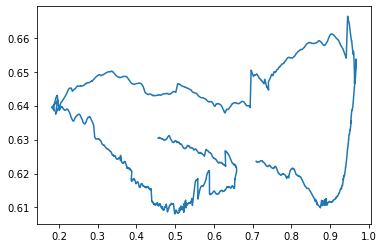

In [223]:
plt.plot(data.x/1280,data.y/720)

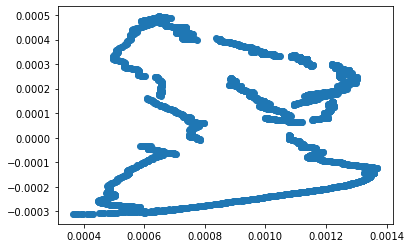

In [211]:
plt.scatter(pred[:,0]*maxes[0],pred[:,1]*maxes[1])

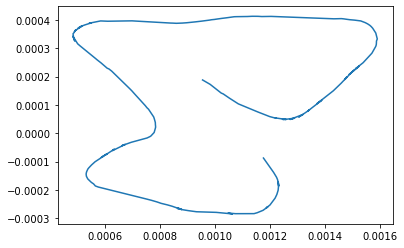

In [184]:
plt.plot(full_data_6.lon_lin.values[:],full_data_6.lat_lin.values[:])